# Time Series Tunnel Traffic Data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ts-course-data/flu-trends.csv
/kaggle/input/ts-course-data/book_sales.csv
/kaggle/input/ts-course-data/elecdemand.csv
/kaggle/input/ts-course-data/trig.csv
/kaggle/input/ts-course-data/avocados.csv
/kaggle/input/ts-course-data/co2.csv
/kaggle/input/ts-course-data/ar.csv
/kaggle/input/ts-course-data/reserve.csv
/kaggle/input/ts-course-data/us-retail-sales.csv
/kaggle/input/ts-course-data/tunnel.csv
/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

In [3]:
data_path = "../input/ts-course-data/tunnel.csv"
# convert Day column to datetime type
tunnel = pd.read_csv(data_path, parse_dates = ["Day"])

In [4]:
tunnel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day          747 non-null    datetime64[ns]
 1   NumVehicles  747 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.8 KB


In [5]:
tunnel = tunnel.set_index("Day")

In [6]:
tunnel = tunnel.to_period()

In [7]:
tunnel.index

PeriodIndex(['2003-11-01', '2003-11-02', '2003-11-03', '2003-11-04',
             '2003-11-05', '2003-11-06', '2003-11-07', '2003-11-08',
             '2003-11-09', '2003-11-10',
             ...
             '2005-11-07', '2005-11-08', '2005-11-09', '2005-11-10',
             '2005-11-11', '2005-11-12', '2005-11-13', '2005-11-14',
             '2005-11-15', '2005-11-16'],
            dtype='period[D]', name='Day', length=747)

In [8]:
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


In [9]:
df = tunnel.copy()

In [10]:
df['Time'] = np.arange(len(tunnel.index))

In [11]:
df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


In [12]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Time']]
y = df.loc[:, 'NumVehicles']

model = LinearRegression()
model.fit(X,y)

y_pred = pd.Series(model.predict(X), index=X.index)

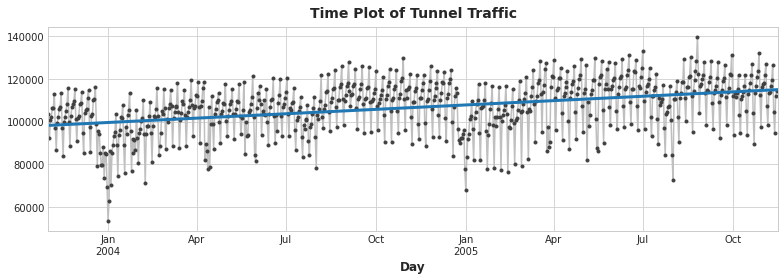

In [13]:
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

## Lag feature

In [14]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


In [15]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)
y = df.loc[:, 'NumVehicles']
y,X = y.align(X, join = 'inner')

model = LinearRegression()
model.fit(X,y)

y_pred = pd.Series(model.predict(X), index = X.index)

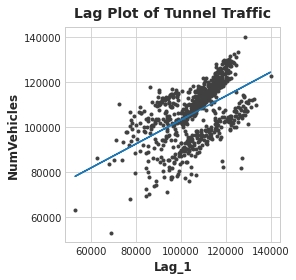

In [16]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

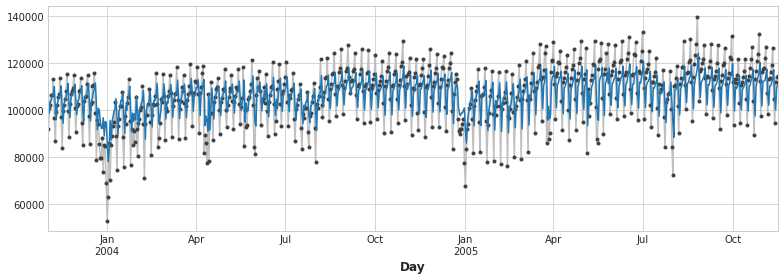

In [17]:
ax = y.plot(**plot_params)
ax = y_pred.plot()